# Compare simulation and mean field for Potjans' model


In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

save_fig = True
figure_path = os.path.join(".", "figures")
reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 2 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


## Mean field model

In [2]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        if u < -4.0:
            return np.exp(x**2) * \
                np.exp(-u**2) / np.sqrt(np.pi) * (u**-2
                                                    - u**-4
                                                    + 7.0 * u**-6 / 4.0
                                                    - 9.0 * u**-8 / 2.0)
        else:
            return np.exp(x**2) * np.exp(u**2) * (1. + erf(u))**2

    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [6]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=0.7, ms=style.cross_size)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=1, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=1., ms=style.cross_size / style.legend_ms) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

## With connection_rule = "fixed_total_number":

Use jacobian
Integration time: 0.11
CV calc time: 0.52


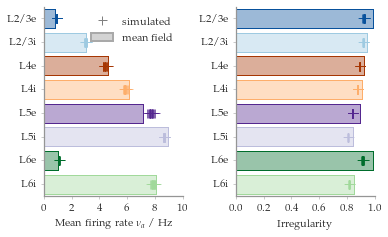

In [7]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
jacobian=True
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          jacobian=jacobian,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all  = np.zeros((n_sims, n_populations))
    cv_isi_mean_all = np.zeros((n_sims, n_populations))
    synchrony_all   = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        synchrony_all[j]    = res_grp["synchrony"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()
fig.set_size_inches(*style.figsize) 

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean firing rate $\\nu_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)



for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_total_number"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Print numerical results: Rates and CV of ISI (for latex)

In [22]:
def print_line(data, max_i=2):
    dstr = ""
    for d in data:
        if abs(d) < 0.01:
            dstr += "& %.e"%d
            dstr = dstr[:-2] + dstr[-1]
        else:
            dstr += ("& {0:%i.%if} "%(max_i + 4, max_i)).format(d)

    dstr += r"\tn[0.2cm]"
    return dstr

# Firing rates
r_mf = rate_mf
r_sim = np.mean(rates_mean_all, axis=0)

# Absolute deviation for rates
drs = (r_mf - r_sim)
drstr = print_line(drs, max_i=2)
# Relative deviation for rates
rdrs = drs / r_sim
rdrstr = print_line(rdrs, max_i=2)

    
# String for Table    
tabstr  = r"$\Delta \nu_a$ / Hz"  + "\n    "
tabstr += drstr  + "\n"
tabstr += r"$\Delta \nu_a / \nu_{\text{sim}, a}$"  + "\n    "
tabstr += rdrstr 
print(tabstr)
mean_str_rate = "$({0:4.2f} \\pm {1:4.2f})$ Hz".format(np.mean(abs(drs)), np.std(abs(drs)))

# CV of ISI
cv_mf = cv_isi_mf 
cv_sim = np.mean(cv_isi_mean_all, axis=0)

# Absolute deviation for rates
dcv = (cv_mf - cv_sim)
dcvstr = print_line(dcv, max_i=2)
# Relative deviation for rates
rdcv = dcv / cv_sim
rdcvstr = print_line(rdcv, max_i=2)



# String for Table    
tabstr  = r"$\Delta \text{CV}_a$"  + "\n    "
tabstr += dcvstr  + "\n"
tabstr += r"$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$"  + "\n    "
tabstr += rdcvstr  + "\n"
print(tabstr)

mean_str = "$({0:4.2f} \\pm {1:4.2f})$".format(np.mean(abs(dcv)), np.std(abs(dcv)))
proz_str = "$({0:d} \\pm {1:d})$".format(int(np.mean(abs(dcv)) / np.mean(cv_sim) * 100), 
                                       int(np.std(abs(dcv)) / np.mean(cv_sim) * 100))



print(mean_str_rate)
print("\n")
print(mean_str)
print(proz_str)

$\Delta \nu_a$ / Hz
    &  -0.10 &   0.01 &   0.24 &   0.28 &  -0.56 &   0.27 &  -0.06 &   0.24 \tn[0.2cm]
$\Delta \nu_a / \nu_{\text{sim}, a}$
    &  -0.11 & 4e-3&   0.05 &   0.05 &  -0.07 &   0.03 &  -0.05 &   0.03 \tn[0.2cm]
$\Delta \text{CV}_a$
    &   0.07 &   0.03 &   0.03 &   0.03 &   0.05 &   0.04 &   0.08 &   0.04 \tn[0.2cm]
$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$
    &   0.07 &   0.03 &   0.03 &   0.04 &   0.06 &   0.05 &   0.08 &   0.05 \tn[0.2cm]

$(0.22 \pm 0.16)$ Hz


$(0.04 \pm 0.02)$
$(5 \pm 2)$


In [11]:
rate_mf

array([ 0.82377035,  3.01729895,  4.63565199,  6.11507966,  7.13734708,
        8.91867088,  1.04448376,  8.08614899])

(array([ 4.22348797,  3.26064097,  4.47523741,  2.52197922,  7.20709458,
         1.54285795,  1.67353431,  1.27777212]),
 array([ 0.40763013,  1.42170329,  2.12782152,  2.76011386,  3.1587064 ,
         3.70914971,  0.51566455,  3.39939241]),
 array([ 10.36107891,   2.29347501,   2.1032015 ,   0.91372289,
          2.28166017,   0.41596001,   3.24539336,   0.3758825 ]))

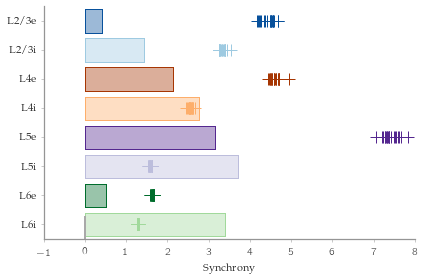

In [54]:

del_t = 3 * 1e-3 # s, time bin
synchrony_mf =  rate_mf * cv_isi_mf**2 / (1 + cv_isi_mf**2)

fig = plt.figure()

ax3 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(synchrony_all, synchrony_mf, ax3)
ax3.set_xlabel("Synchrony")

for ax in fig.axes:
    style.fixticks(ax)
    
synchrony_all[0], synchrony_mf, synchrony_all[0] / synchrony_mf

## With connection_rule = "fixed_indegree" and different synapse model:

Integration time: 0.07
CV calc time: 0.50


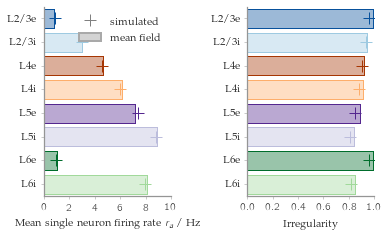

In [64]:
#sim_spec = "a1.0_t20.2_fixindeg_01"
sim_spec = "simulation_at_mf"
neuron_model    = "iaf_psc_delta"
connection_rule = "fixed_indegree"

######################################################
# Mean field results
######################################################

weight_rel_sd   = 0.1
model     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model, v_guess_0,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA

data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    cv_isi_mean_all     = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()
fig.set_size_inches(*style.figsize) 

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
data = cv_isi_mean_all
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_indegree"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

# Check $\mu$ and $\sigma$
### For consistency, and for the numerical stability of the algorithm applied...

In [10]:
mu_brunel = model_micro.mu(rate_mf[::-1])
sd_brunel = model_micro.sd(rate_mf[::-1])
mu_brunel, sd_brunel

(array([ 35.95056827,  41.19447994,   3.9172597 ,  20.65606839,
         50.05094192,  34.03839799,  40.74860721,  37.68801014]),
 array([ 5.8335019 ,  4.80950918,  5.48111228,  6.18623123,  4.504506  ,
         3.73627247,  3.47004715,  2.66128992]))

### Check numerics

For various intial conditions:
> Those measured in simulation

> Those from simulated transition

In [4]:
def check_solve(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root, fsolve
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    v0  = sol["x"]
    return v0, sol
        

In [127]:
weight_rel_sd   = 0.1
neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"

model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 


# Rates from transition
print("Rates from transition")
v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
for jacobian in [False, True]:
    print("Use jacobian:", jacobian)

    #jacobian=False
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**4}

    t_int0      = time.time()
    rate_mf, sol = check_solve(model_micro, v_guess_0,
                    jacobian=jacobian, root_method=root_method, options=options)
    t_int1      = time.time() - t_int0

    res_str = "\tt_int: %.2f\t nfev: %i\t success: "%(t_int1, sol["nfev"]) + str(sol["success"])
    print(res_str)
    
print("\nRates from simulation")
for jacobian in [False, True]:
    print("Use jacobian:", jacobian)
    n_success = 0
    n_sims = len(rates_mean_all)
    tints = np.zeros(n_sims)
    nfevs = np.zeros(n_sims) 
    for j in range(n_sims):
        v_guess_0       = rates_mean_all[j]
        
        #jacobian=False
        root_method='hybr'
        options= {"xtol": 1e-13, "maxfev": 10**4}

        t_int0      = time.time()
        rate_mf, sol = check_solve(model_micro, v_guess_0,
                        jacobian=jacobian, root_method=root_method, options=options)
        t_int1      = time.time() - t_int0
        
        res_str = "%i\tt_int: %.2f\t nfev: %i\t success: "%(j, t_int1, sol["nfev"]) + str(sol["success"])
        print(res_str)
        
        n_success += sol["success"]
        tints[j] = t_int1
        nfevs[j] = sol["nfev"]
        
    print(np.mean(tints), np.mean(nfevs))
    print("%i out of %i\n"%(n_success, n_sims))

Rates from transition
Use jacobian: False
	t_int: 0.14	 nfev: 46	 success: True
Use jacobian: True
	t_int: 0.22	 nfev: 79	 success: True

Rates from simulation
Use jacobian: False
0	t_int: 0.11	 nfev: 38	 success: True
1	t_int: 0.26	 nfev: 27	 success: False
2	t_int: 0.17	 nfev: 60	 success: True
3	t_int: 0.12	 nfev: 42	 success: True
4	t_int: 0.25	 nfev: 86	 success: True
5	t_int: 0.13	 nfev: 42	 success: True
6	t_int: 0.11	 nfev: 37	 success: True
7	t_int: 0.13	 nfev: 44	 success: True
8	t_int: 0.14	 nfev: 45	 success: True
9	t_int: 0.13	 nfev: 44	 success: True
10	t_int: 0.12	 nfev: 40	 success: True
11	t_int: 0.14	 nfev: 45	 success: True
12	t_int: 0.21	 nfev: 68	 success: True
13	t_int: 0.17	 nfev: 57	 success: True
14	t_int: 0.11	 nfev: 36	 success: True
15	t_int: 0.13	 nfev: 42	 success: True
16	t_int: 0.13	 nfev: 42	 success: True
17	t_int: 0.11	 nfev: 37	 success: True
18	t_int: 0.12	 nfev: 42	 success: True
19	t_int: 0.11	 nfev: 38	 success: True
0.144635474682 45.6
19 out of

### Compare solver for Brunel and Micro

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


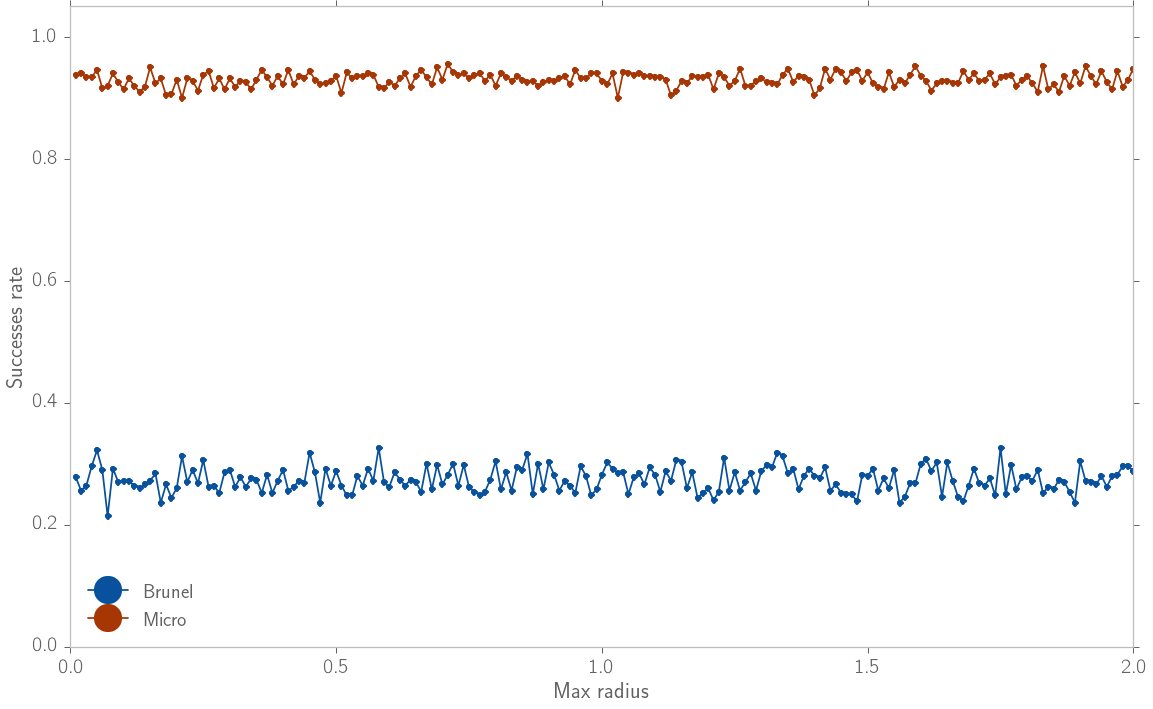

In [5]:
# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 2.0
weight_rel_sd   = 0.1
n_neurons       = "micro"
C_ab            = "micro"
model_micro       = model_class.model() 
model_names = ["Brunel", "Micro"]

data_path        = "/users/schuessler/uni/microcircuit/analysis"
res_file_name   = "check_numerics.hdf5"
path_res_file   = os.path.join(data_path, res_file_name)
with h5py.File(path_res_file, "r") as  res_file:
    r_max_all     = res_file["r_max_all"][:]
    tints_mean    = res_file["tints_mean"][:]
    nfevs_mean    = res_file["nfevs_mean"][:]
    success_rate  = res_file["success_rate"][:]
    
fig = plt.figure()

ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
for k, model_name in enumerate(model_names):
    ax.plot(r_max_all, success_rate[k], '-o', color=colors[k*2], label=model_name)
    
ax.set_xlim(0, r_max_all[-1])
ax.set_xlabel("Max radius")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Successes rate")
ax.grid(False)
ax.legend(loc="best")


## Test dependency on $\Delta J$

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

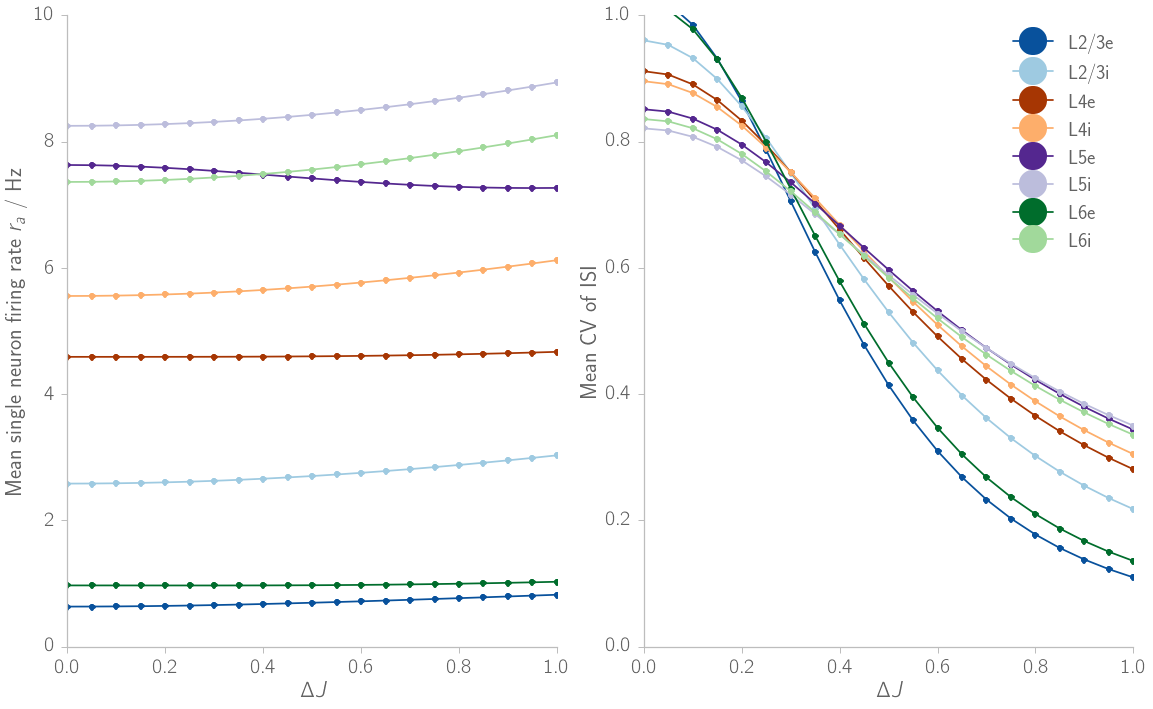

In [85]:
# Data
sim_spec = "a1.0_t20.4_00"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

n = 21
weight_rel_sds   = np.linspace(0, 1.0, n)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"


v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for j, weight_rel_sd in enumerate(weight_rel_sds):
    print(j, end=" ")

    model_micro     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        weight_rel_sd=weight_rel_sd) 
    t_int0      = time.time()
    rates[j]     = solve_model(model_micro, v_guess_0,
                              root_method=root_method, options=options)
    t_int1      = time.time() - t_int0
    #print("Integration time: %.2f"%(t_int1))

    t_int0      = time.time()
    cv_isis[j]   = CV_ISI_mf(rate_mf, model=model_micro)
    t_int1      = time.time() - t_int0
    #print("CV calc time: %.2f"%(t_int1))


fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(populations):
    ax1.plot(weight_rel_sds, rates[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(weight_rel_sds, cv_isis[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    

ax1.set_ylabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_ylim(0, 10)

ax2.set_ylabel("Mean CV of ISI")
ax2.set_ylim(0, 1)
ax2.legend(loc="best")

for ax in fig.axes:
    ax.set_xlabel("$\Delta J$")
    style.fixticks(ax)